In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from sklearn.model_selection import train_test_split # Splitting dataset
from sklearn.neighbors import KNeighborsClassifier #Tool for KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [31]:
# Load your data
df = pd.read_csv('/Users/Akesitakkharasaksiri/Desktop/KMITL/YEAR 2/Project/AI/panya1 - Report.csv')

# Handle non-numeric values and missing data
df = df.apply(pd.to_numeric, errors='coerce')
df.fillna(df.mean(), inplace=True)
# Convert 'Predicted Condition' to numerical values using one-hot encoding

# Select your features and target variable
X = df[['Amount of PV panel','WATT','Temperature(°F)', 'Humidity (%)', 'Wind Speed (mph)', 'Pressure (in)','Hours']]
y = df['PV Yield (kWh)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the number of samples after preprocessing
print(f"Number of samples after preprocessing: {len(df)}")


Number of samples after preprocessing: 2704


In [32]:
#seaborn is a library to create plots for statistical data
corr = df.corr() #compute the correlation matrix
corr.style.background_gradient(cmap='Pastel2') #summer,winter

,PV Yield (kWh),Amount of PV panel,WATT,Temperature(°F),Humidity (%),Wind Speed (mph),Pressure (in),Hours,where
PV Yield (kWh),1.000000,0.891138,0.519012,0.015824,-0.227243,0.105343,-0.179552,0.059249,-0.521826
Amount of PV panel,0.891138,1.000000,0.551511,-0.000987,-0.142663,0.069993,-0.071350,0.043195,-0.583163
WATT,0.519012,0.551511,1.000000,-0.012712,-0.056446,0.003181,-0.067779,0.049501,-0.120335
Temperature(°F),0.015824,-0.000987,-0.012712,1.000000,-0.007444,0.194469,-0.030482,-0.478448,-0.033609
Humidity (%),-0.227243,-0.142663,-0.056446,-0.007444,1.000000,-0.264360,0.059470,-0.228218,0.291169
Wind Speed (mph),0.105343,0.069993,0.003181,0.194469,-0.264360,1.000000,-0.119970,-0.355526,-0.164387
Pressure (in),-0.179552,-0.071350,-0.067779,-0.030482,0.059470,-0.119970,1.000000,0.033274,0.114287
Hours,0.059249,0.043195,0.049501,-0.478448,-0.228218,-0.355526,0.033274,1.000000,-0.075474
where,-0.521826,-0.583163,-0.120335,-0.033609,0.291169,-0.164387,0.114287,-0.075474,1.000000


<Axes: >

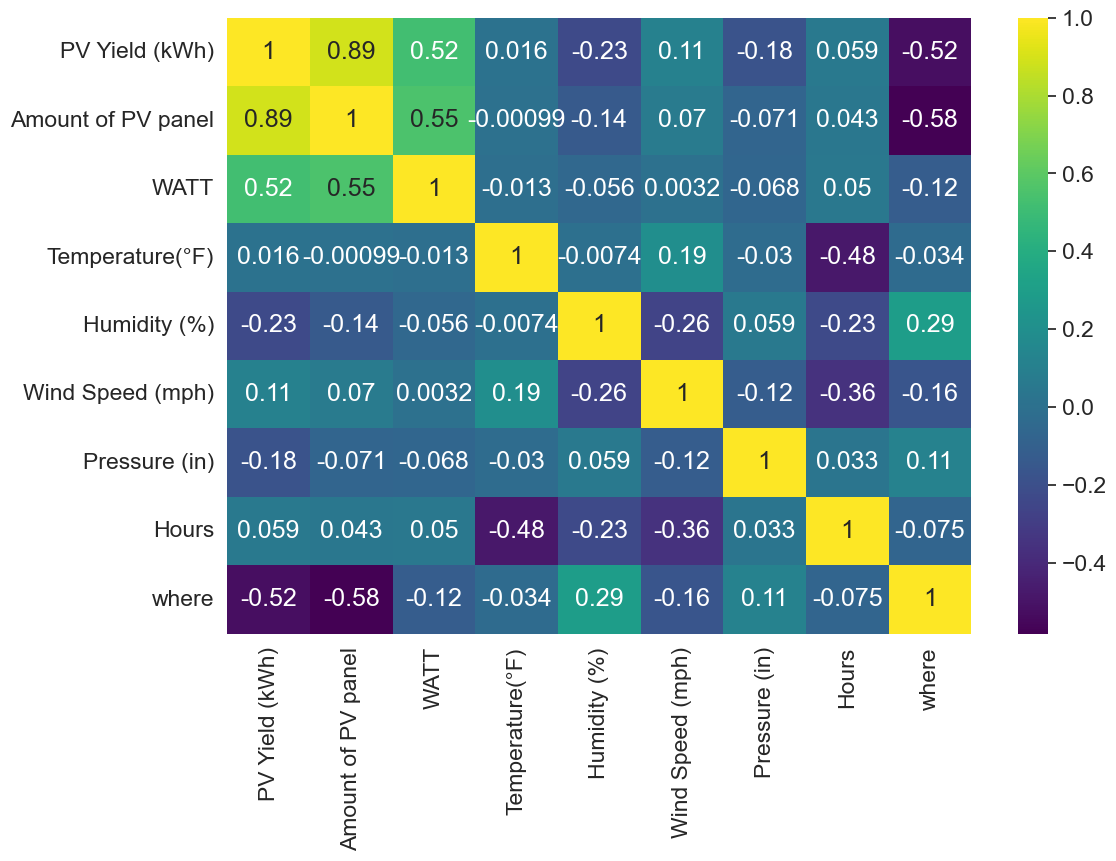

In [33]:
#Correlation matrix
sns.set(style='white', color_codes=True)
sns.set(font_scale=1.5)
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True,cmap="viridis")

In [34]:
# K-Nearest Neighbors Regressor
knn_reg = KNeighborsRegressor(n_neighbors=3)  
knn_reg.fit(X_train, y_train)
y_pred_knn_reg = knn_reg.predict(X_test)

# Random Forest Regressor with GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf,
                       cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_
y_pred_rf_reg = best_rf_model.predict(X_test)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)  # Try different values for hyperparameters
gb_model.fit(X_train, y_train)
y_pred_gb_reg = gb_model.predict(X_test)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END m

In [35]:
# For KNN
mae_knn = mean_absolute_error(y_test, y_pred_knn_reg)


# RF
rf_mae = mean_absolute_error(y_test, y_pred_rf_reg)


#GB
gb_mae = mean_absolute_error(y_test, y_pred_gb_reg)


# Print the evaluation metrics
print(f"KNN:                         MAE={mae_knn}")
print(f"Random Forest Regressor:     MAE={rf_mae}")
print(f"Gradient Boosting Regressor: MAE={gb_mae}")


KNN:                         MAE=5.736204559457795
Random Forest Regressor:     MAE=4.631491669083761
Gradient Boosting Regressor: MAE=4.449431257578093


In [36]:
# New data for prediction
a=[24,	500,	87.3,	70.2,	7.1,	29.8,	11.55,0]

new_data = pd.DataFrame({
    'Amount of PV panel':[a[0]],#number of solar cell 
    'WATT':[a[1]],#WAtt per solarcell
    'Temperature(°F)': [a[2]],#Temp in F
    'Humidity (%)': [a[3]],#Humidity
    'Wind Speed (mph)': [a[4]],#Wind speed in mph
    'Pressure (in)': [a[5]],#Pressure
    'Hours': [a[6]]#Hours
})

# Actual PV Yield value for the date
actual_pv_yield = [a[7]] #actual_pv_yield 

# Predictions for the new data
predicted_pv_yield_knn = knn_reg.predict(new_data)
rf_pred                = best_rf_model.predict(new_data)
gb_pred                = gb_model.predict(new_data)

#Weighting the prediction
inv_mae_knn = 1/mae_knn
inv_rf_mae = 1/rf_mae
inv_gb_mae = 1/gb_mae
# Calculate the total of the MAEs
total_mae =   inv_mae_knn + inv_rf_mae + inv_gb_mae

# Calculate the weights for each model based on the inverse of MAE
weight_knn = inv_mae_knn / total_mae
weight_rf = inv_rf_mae / total_mae
weight_gb = inv_gb_mae / total_mae

# Calculate the weighted average of the predictions
weighted_prediction = (weight_knn* predicted_pv_yield_knn +
                      weight_rf * rf_pred +
                      weight_gb * gb_pred)


# Print the weighted average prediction
print(f"actual_pv_yield                                   : {actual_pv_yield[0]}")
# Print the predicted PV Yield (kWh) for each model
print(f"KNN Predicted PV Yield (kWh)                      : {predicted_pv_yield_knn[0]}")
print(f"Random Forest Regressor Predicted PV Yield (kWh)  : {rf_pred[0]}")
print(f"GradientBoostingRegressor Predicted PV Yield (kWh): {gb_pred[0]}")
print(f"Weighted Average Predicted PV Yield (kWh)         : {weighted_prediction[0]}")
print(f"Accuracy%                                         : {((weighted_prediction[0] - actual_pv_yield[0])/actual_pv_yield[0])*100}")

actual_pv_yield                                   : 0
KNN Predicted PV Yield (kWh)                      : 20.103333333333335
Random Forest Regressor Predicted PV Yield (kWh)  : 21.11750404761905
GradientBoostingRegressor Predicted PV Yield (kWh): 23.139375367537138
Weighted Average Predicted PV Yield (kWh)         : 21.56890724370478
Accuracy%                                         : inf


/var/folders/jn/mp5kqhqn2tqg05_5hs3__yxc0000gn/T/ipykernel_91019/4131267497.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Accuracy%                                         : {((weighted_prediction[0] - actual_pv_yield[0])/actual_pv_yield[0])*100}")


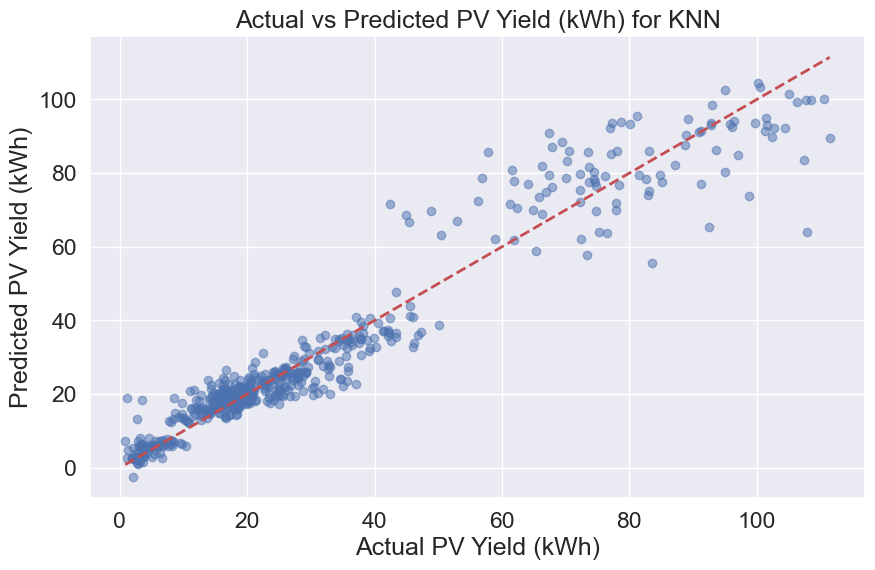

In [37]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb_reg, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PV Yield (kWh)')
plt.ylabel('Predicted PV Yield (kWh)')
plt.title('Actual vs Predicted PV Yield (kWh) for KNN')
plt.show()